# A simple 2D Discrete Flow Matching model

This notebook trains and evaluates a simple 2D discrete FM model with $\kappa_t = t^2$ scheduler.

Dataset: 2D discrete checkerboard
Model (probability denoiser): MLP

## Imports and init device

In [2]:
import time
import torch

from torch import nn, Tensor

# flow_matching
from flow_matching.path import MixtureDiscreteProbPath
from flow_matching.path.scheduler import PolynomialConvexScheduler
from flow_matching.solver import MixtureDiscreteEulerSolver
from flow_matching.utils import ModelWrapper
from flow_matching.loss import MixturePathGeneralizedKL
from flow_matching.solver import Solver, ODESolver

# visualization
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [3]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')

Using cpu.


In [4]:
torch.manual_seed(42)

## Dataset

In [5]:
def inf_train_gen(n_grid_points: int = 128, batch_size: int = 200, device: str = "cpu") -> Tensor:
    assert n_grid_points % 4 == 0, "number of grid points has to be divisible by 4"
    
    n_grid_points = n_grid_points // 4
    
    x1 = torch.randint(low=0, high=n_grid_points * 4, size=(batch_size,), device=device)
    samples_x2 = torch.randint(low=0, high=n_grid_points, size=(batch_size,), device=device)
    
    x2 = (
        samples_x2
        + 2 * n_grid_points
        - torch.randint(low=0, high=2, size=(batch_size,), device=device) * 2 * n_grid_points
        + (torch.floor(x1 / n_grid_points) % 2) * n_grid_points
    )
    
    x_end = 1.0 * torch.cat([x1[:, None], x2[:, None]], dim=1)

    return x_end.long()

## Model

In [6]:
# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor: 
        return torch.sigmoid(x) * x

# Model class
class DiscreteMLP(nn.Module):
    def __init__(
        self, input_dim: int = 128, z_dim: int = 128, time_dim: int = 1, hidden_dim=128, z_hidden_dim=128, length=2):
        super().__init__()
        self.input_dim = input_dim
        self.z_dim = z_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.time_embedding = nn.Linear(1, time_dim)
        self.z_time_embedding = nn.Linear(1, time_dim)
        self.token_embedding = torch.nn.Embedding(self.input_dim, hidden_dim)

        self.z_enc = nn.Sequential(
            nn.Linear(self.z_dim + time_dim, z_hidden_dim),
            Swish(),
            nn.Linear(z_hidden_dim, z_hidden_dim)
        )

        self.main = nn.Sequential(
            Swish(),
            nn.Linear(hidden_dim * length + time_dim + z_hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, self.input_dim * length),
        )

    def forward(self, x, t, z, t_z):
        t = self.time_embedding(t.unsqueeze(-1))
        t_z = self.z_time_embedding(t_z.unsqueeze(-1))
        x = self.token_embedding(x)
        z = self.z_enc(torch.cat([z, t_z], dim=1))

        B, N, d = x.shape
        x = x.reshape(B, N * d)
        
        h = torch.cat([x, z, t], dim=1)
        h = self.main(h)

        h = h.reshape(B, N, self.input_dim)

        return h

class ContMLP(nn.Module):
    def __init__(self, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            nn.Linear(input_dim+time_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
            )
    

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)
        
        return output.reshape(*sz)

In [7]:
def euler_sde_sample(model, x, brownian_coefs, step_size, end_t):
    sol = [x]
    t = 0
    while t < end_t:
        t_tensor = torch.ones(x.shape[0]).to(x.device)*t
        x += model(x,t_tensor)*step_size + brownian_coefs*torch.randn_like(x)*np.sqrt(step_size)
        sol += [x]
        t += step_size
    return torch.stack(sol, dim = 1)    

def sample_z_t(model, z_dim, brownian_coefs = 0.01, batch_size = 50000, step_size = 0.1):
    total_steps = int(1//step_size)+1
    T = torch.randint(0, total_steps+1, (batch_size,))
    T = T.to(device=device)

    x_init = torch.randn((batch_size, z_dim), dtype=torch.float32, device=device)
    sol = euler_sde_sample(model, x_init, brownian_coefs, step_size, 1)
    return sol[torch.arange(batch_size), T], step_size*T

def sample_z_endt(model, z_dim, end_t, brownian_coefs = 0.01, batch_size = 50000, step_size = 0.1):
    x_init = torch.randn((batch_size, z_dim), dtype=torch.float32, device=device)
    sol = euler_sde_sample(model, x_init, brownian_coefs, step_size, end_t)
    return sol[:, -1], torch.ones(x_init.shape[0]).to(x_init.device)*end_t

## Train Discrete Flow Matching model with a uniform source distribution

In [77]:
source_distribution = "uniform"

# training arguments
lr = 0.001
batch_size = 4096
iterations = 30001
print_every = 100

vocab_size = 128
hidden_dim = 128

epsilon = 1e-3

z_dim = 8

if source_distribution == "uniform":
    added_token = 0
elif source_distribution == "mask":
    mask_token = vocab_size  # tokens starting from zero
    added_token = 1
else:
    raise NotImplementedError
    
# additional mask token
vocab_size += added_token

# probability denoiser model init
z_model = ContMLP(input_dim = z_dim, time_dim = 1, hidden_dim = hidden_dim)
probability_denoiser = DiscreteMLP(input_dim=vocab_size, z_dim = z_dim, time_dim=1, hidden_dim=hidden_dim, z_hidden_dim=hidden_dim).to(device)

# instantiate a convex path object
scheduler = PolynomialConvexScheduler(n=2.0)
path = MixtureDiscreteProbPath(scheduler=scheduler)

# init optimizer
optim = torch.optim.Adam(list(probability_denoiser.parameters()) + list(z_model.parameters()), lr=lr) 

loss_fn = MixturePathGeneralizedKL(path=path)

# train
start_time = time.time()

steps = 0
losses = []
for i in range(iterations):
    optim.zero_grad() 

    # sample data (user's responsibility): in this case, (X_0,X_1) ~ pi(X_0,X_1)
    x_1 = inf_train_gen(n_grid_points=vocab_size - added_token, batch_size=batch_size, device=device) # sample data
    
    if source_distribution == "uniform":
        x_0 = torch.randint_like(x_1, high=vocab_size)
    elif source_distribution == "mask":
        x_0 = torch.zeros_like(x_1) + mask_token
    else:
        raise NotImplementedError

    # sample time (user's responsibility)
    t = torch.rand(x_1.shape[0]).to(device) * (1 - epsilon)

    # sample probability path
    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
    # z_t, t_z = sample_z_t(z_model, z_dim, batch_size = batch_size)
    end_t = torch.randint(0, 11, (1,))*0.1
    z_t, t_z = sample_z_endt(z_model, z_dim, end_t, batch_size = batch_size)

    # discrete flow matching generalized KL loss
    logits = probability_denoiser(x=path_sample.x_t, t=path_sample.t, z=z_t, t_z=t_z)
    loss = loss_fn(logits=logits, x_1=x_1, x_t=path_sample.x_t, t=path_sample.t)

    # optimizer step
    loss.backward() # backward
    optim.step() # update
    
    # log loss
    if (i+1) % print_every == 0:
        elapsed = time.time() - start_time
        print('| iter {:6d} | {:5.2f} s/step | loss {:8.3f} ' 
              .format(i+1, elapsed/print_every, loss.item())) 
        start_time = time.time()

| iter    100 |  0.34 s/step | loss    9.865 
| iter    200 |  0.34 s/step | loss    9.954 
| iter    300 |  0.33 s/step | loss    9.481 
| iter    400 |  0.35 s/step | loss    8.858 
| iter    500 |  0.35 s/step | loss    9.949 
| iter    600 |  0.37 s/step | loss    9.285 
| iter    700 |  0.36 s/step | loss    9.544 
| iter    800 |  0.34 s/step | loss    8.628 
| iter    900 |  0.35 s/step | loss    7.132 
| iter   1000 |  0.54 s/step | loss    6.717 
| iter   1100 |  0.61 s/step | loss    6.223 
| iter   1200 |  0.50 s/step | loss    6.077 
| iter   1300 |  0.34 s/step | loss    6.106 
| iter   1400 |  0.35 s/step | loss    6.424 
| iter   1500 |  0.34 s/step | loss    5.878 
| iter   1600 |  0.38 s/step | loss    6.079 
| iter   1700 |  0.34 s/step | loss    6.046 
| iter   1800 |  0.36 s/step | loss    5.850 
| iter   1900 |  0.36 s/step | loss    6.541 
| iter   2000 |  0.79 s/step | loss    5.687 
| iter   2100 |  0.48 s/step | loss    5.663 
| iter   2200 |  0.35 s/step | los

In [78]:
torch.save(z_model, 'z_model.pth')
torch.save(probability_denoiser, 'x_model.pth')

In [11]:
source_distribution = "uniform"

# training arguments
lr = 0.001
batch_size = 4096
iterations = 30001
print_every = 100

vocab_size = 128
hidden_dim = 128

epsilon = 1e-3

z_dim = 8

if source_distribution == "uniform":
    added_token = 0
elif source_distribution == "mask":
    mask_token = vocab_size  # tokens starting from zero
    added_token = 1
else:
    raise NotImplementedError
    
# additional mask token
vocab_size += added_token

z_model = torch.load('z_model.pth')
probability_denoiser = torch.load('x_model.pth')

/tmp/ipykernel_389769/2220041038.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  z_model = torch.load('z_model.pth')
/tmp/ipykernel_389769/2220041038.py:28: FutureWarni

#### Sample from trained model

In [16]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, z: torch.Tensor, t_z: torch.Tensor, **extras):
        return torch.softmax(self.model(x, t, z, t_z), dim=-1)

wrapped_probability_denoiser = WrappedModel(probability_denoiser)
solver = MixtureDiscreteEulerSolver(model=wrapped_probability_denoiser, path=path, vocabulary_size=vocab_size)

In [17]:
nfe = 64
step_size = 1 / nfe

safe_sampling = True
n_samples = 100000
dim = 2

if source_distribution == "uniform":
    x_init = torch.randint(size=(n_samples, dim), high=vocab_size, device=device)
elif source_distribution == "mask":
    x_init = (torch.zeros(size=(n_samples, dim), device=device) + mask_token).long()
else:
    raise NotImplementedError

scheduler = PolynomialConvexScheduler(n=2.0)
path = MixtureDiscreteProbPath(scheduler=scheduler)

n_plots = 9
linspace_to_plot = torch.linspace(0,  1 - epsilon, n_plots)

z, t_z = sample_z_endt(z_model, z_dim, 1, batch_size = n_samples)

sol = solver.sample(x_init=x_init,
                    z = z,
                    t_z = t_z,
                    step_size=step_size, 
                    verbose=True, 
                    return_intermediates=True,
                    time_grid=linspace_to_plot)

NFE: 64: 100%|██████████| 0.9990000128746033/0.9990000128746033 [02:11<00:00, 131.96s/it]


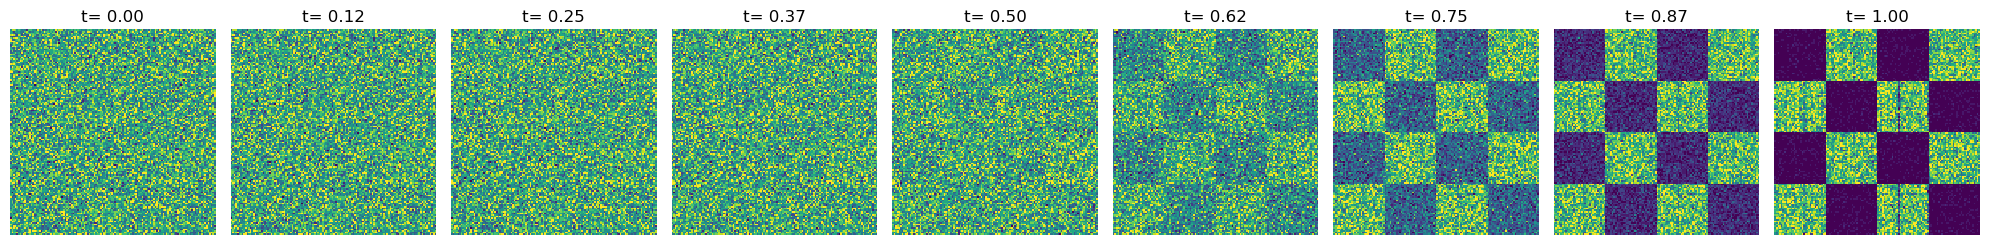

In [18]:
sol = sol.cpu().numpy()

fig, axs = plt.subplots(1, n_plots, figsize = (20, 20))

if source_distribution == "mask":
    mask_tensor = torch.tensor([mask_token, mask_token]).unsqueeze(0)

for idx, step in enumerate(linspace_to_plot):
    step = int(step.item() * nfe)
    
    if source_distribution == "uniform":
        sol_step = sol[idx, ...]
    elif source_distribution == "mask":        
        sol_step = sol[idx, ...]
        sol_step = sol_step[torch.ne(torch.from_numpy(sol_step), mask_tensor).all(dim=1), ...]
        
        if sol_step.size == 0:
            axs[idx].hist2d([], [], bins=10)
            axs[idx].set_aspect('equal')
            axs[idx].axis('off')
            axs[idx].set_title('t= %.2f' % (step * step_size))
            
            continue
    else:
        raise NotImplementedError

    H = axs[idx].hist2d(sol_step[:, 0], sol_step[:, 1], bins=vocab_size)
    
    cmin = 0.0
    cmax = torch.quantile(torch.from_numpy(H[0]), 0.95).item()
    
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    
    _ = axs[idx].hist2d(sol_step[:, 0], sol_step[:, 1], bins=vocab_size, norm=norm)
    
    axs[idx].set_aspect('equal')
    axs[idx].axis('off')
    axs[idx].set_title(f't= {linspace_to_plot[idx].item():.2f}')
    
plt.tight_layout()
plt.show()

## Visualize ELBO

In [10]:
n_discretization = 1024  # Time discretization of integration interval
n_samples = 10  # Number of samples to approximate the expectation on X_t ~ p_t(\cdot| x_1)

# Generalized KL function (will use it to compute the elbo)
generalized_kl_fn = MixturePathGeneralizedKL(
    path = path,
    reduction ='none'
)

# Grid of vocab_size X vocab_size
grid = torch.meshgrid(
    torch.arange(0, vocab_size, device=device),
    torch.arange(0, vocab_size, device=device),
    indexing='ij'
)
x_1 = torch.stack(
    [grid[0].reshape(-1), grid[1].reshape(-1)],
    dim=1
)

# Time discretization
discretization = (
    torch.linspace(0, 1, n_discretization + 1, device=device)[:-1]
    .view(-1, 1)
    .repeat(1, x_1.shape[0])
)

elbo = torch.zeros(size=(x_1.shape[0],), device=device)

with torch.no_grad():
    for _ in range(n_samples):
        # Lower variance estimator for time discretization
        discretization = discretization + torch.rand(
            size=(1, x_1.shape[0]), device=device
        )
        discretization = discretization % 1
        discretization = discretization * (1 - epsilon)
        
        for t in discretization:
            # sample X_t ~ p_t(\cdot| x_1)
            if source_distribution == "uniform":
                x_0 = torch.randint(size=x_1.shape, high=vocab_size, device=device)
            elif source_distribution == "mask":
                x_0 = (torch.zeros(size=x_1.shape, device=device) + mask_token).long()
            else:
                raise NotImplementedError
            
            x_t = path.sample(t=t, x_0=x_0, x_1=x_1).x_t
            
            logits = probability_denoiser(x_t, t)
            
            # compute ELBO
            elbo += -generalized_kl_fn(
                logits=logits, x_1=x_1, x_t=x_t, t=t
            ).sum(dim=1)

    elbo /= n_discretization * n_samples

# Remember that log_q(x_1) >= ELBO(x_1)
probability_lower_bound = torch.exp(elbo)

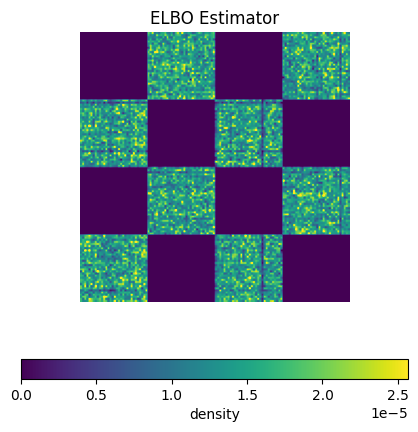

In [11]:
cmin = 0.0
cmax = probability_lower_bound.max().item() / 1.5 

norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

plt.figure(figsize=(5, 5))
plt.imshow(
    probability_lower_bound.reshape(vocab_size, vocab_size).cpu(), 
    origin='lower', cmap='viridis', norm=norm
)
plt.gca().axis("off")
plt.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=plt.gca(), orientation='horizontal', label='density')
plt.title("ELBO Estimator")
plt.show()